In [2]:
import numpy as np
import pandas as pd
from lightfm import LightFM
import scipy
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from sklearn.metrics import f1_score
from statistics import mode
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
# from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [3]:
#Чуть-чуть изменил твой скрипт сборки. Все ОКВЭДы из приватного сета заменил на 1000
result_df = pd.read_csv('../data/result_df_without_private.csv')
#result_df = result_df.iloc[:50000]

#выкидываю приватные ОКВЭДы
result_df = result_df.drop(columns=result_df.filter(regex=("1000")).columns)
result_df = result_df.fillna(0)

In [4]:
result_df_full = pd.read_csv('../data/result_df.csv')

In [5]:
%%time
#оставим отрасли, где ИНН был получателем. Пробовал включать, когда был ИНН являлся и отправителем и оба одновременно - F1 падает.
result_df_kt = result_df.filter(regex=("count_kt"))
#создаем разряженную матрицу для работы с LightFM
train = scipy.sparse.csr_matrix(result_df_kt.values)
item_features = scipy.sparse.csr_matrix(result_df_kt.T.values)

#данная лосс функция использует только к-ый(это гиперпараметр) положительный пример для кажлого пользователя.
#также можно задать максимальное кол-во положительных примеров для каждого апдейта.
model = LightFM(loss='warp-kos')
%time model.fit(train, epochs=180)

print("Train recall: %.2f" % recall_at_k(model, train, k=1).mean())
print("Train precision: %.2f" % precision_at_k(model, train, k=1).mean())

CPU times: user 1min 35s, sys: 375 ms, total: 1min 35s
Wall time: 1min 35s
Train recall: 0.63
Train precision: 0.94


In [15]:
%%time
#оставим отрасли, где ИНН был получателем. Пробовал включать, когда был ИНН являлся и отправителем и оба одновременно - F1 падает.
result_df_kt = result_df.filter(regex=("count_kt"))
#создаем разряженную матрицу для работы с LightFM
train = scipy.sparse.csr_matrix(result_df_kt.values)
item_features = scipy.sparse.csr_matrix(result_df_kt.T.values)

#данная лосс функция использует только к-ый(это гиперпараметр) положительный пример для кажлого пользователя.
#также можно задать максимальное кол-во положительных примеров для каждого апдейта.
model = LightFM(loss='warp-kos')
%time model.fit(train, epochs=180)

print("Train recall: %.2f" % recall_at_k(model, train, k=2).mean())
print("Train precision: %.2f" % precision_at_k(model, train, k=2).mean())

CPU times: user 1min 27s, sys: 210 ms, total: 1min 28s
Wall time: 1min 28s
Train recall: 0.78
Train precision: 0.70
CPU times: user 1min 28s, sys: 266 ms, total: 1min 29s
Wall time: 1min 29s


In [6]:
def sample_recommendation(model, data, user_ids):
    pred = []
    n_users, n_items = data.shape

    for user_id in user_ids:
        
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data.columns[np.argsort(-scores)][:1]
        top_items = [int(i.split('_')[0]) for i in top_items]
        try:
            rec_item = mode(top_items)
        except:
            rec_item = top_items[0]
        pred.append(rec_item)
        
    return pred

In [7]:
#предсказаия для приватного сета
preds = sample_recommendation(
    model,
    result_df.filter(regex=("count_kt")),
    result_df.loc[result_df.okved2==1000].index.values.tolist()
)

In [8]:
#ОКВЭДы для теста
private_df = pd.read_csv('../data/inn_info_private.csv')

In [11]:
print('f1 macro =', f1_score(list(private_df.okved2), preds, average = 'macro'))

f1 macro = 0.05646289768776643


## Embeddings

In [12]:
# Эмбеддинги пользователей
X = model.user_embeddings
# Количество сэмплов в приватном сете
n = list(result_df.loc[result_df.okved2 != 1000].index)[-1]

In [14]:
X

array([[-0.00459005,  0.01647134, -0.0164854 , ..., -0.02546828,
         0.04960518, -0.00968668],
       [ 0.01774091, -0.00839528, -0.0091344 , ..., -0.00576758,
         0.02589128, -0.02846812],
       [-0.03387387, -0.0250726 ,  0.00538957, ...,  0.03261409,
        -0.00470592, -0.00693406],
       ...,
       [ 0.03225213, -0.14612344, -0.41251847, ...,  0.03860876,
        -0.23114811, -0.00596339],
       [ 0.00992431, -0.04604878, -0.00536116, ..., -0.04426794,
         0.00555097, -0.01659499],
       [-0.40018642, -0.2074158 ,  0.12637243, ...,  0.08270162,
         0.19596799, -0.09776124]], dtype=float32)

In [38]:
# косинусная мера
from numpy import dot
from numpy.linalg import norm

def cosine_sim(a, b):
    
    return abs(dot(a, b)/(norm(a)*norm(b)))

### KNeighborsClassifier

In [393]:
# Custom метрика работает очень долго, поэтому предсказываю последние k элементов из приватного сета через 5 различных метрик
k=1000
for metr_dist in [cosine_sim,'euclidean','manhattan','chebyshev','minkowski']:
    
    knn = KNeighborsClassifier(n_neighbors=5, metric = metr_dist)
    # обучаемся на публичном сете
    knn.fit(X[:n+1],result_df['okved2'].iloc[:n+1])
    # предсказываем последние k сэмлов из приватного сета
    knn_pred = knn.predict(X[result_df.shape[0]-k:])
    
    print(metr_dist, f1_score(list(private_df.iloc[private_df.shape[0]-k:].okved2), knn_pred, average = 'macro'))

<function cosine_sim at 0x1a231d9cb0> 0.010490509771014227
euclidean 0.017126894413837024
manhattan 0.020102279399081612
chebyshev 0.020600647113367503
minkowski 0.017126894413837024


Косинусное расстояние в KNN работает очень медленно, на всем датасете ф1(не на последней 1000) будет примерно около 0.03

### Nearst Neighbor embeddings

In [43]:
# NearestNeighbors на эмбеддингах LightFM по встроенной метрике 'cosine'
preds = []
k = 78000

model_knn = NearestNeighbors(metric='cosine', algorithm = 'brute')
model_knn.fit(X)

for ind in tqdm(range(X.shape[0]-k, X.shape[0])):
    
    distance, indicies = model_knn.kneighbors(X[ind,:].reshape(1,-1), n_neighbors=10)
    c = 0
    for i in range(1,len(distance.flatten())):
        inn = result_df_kt.index[indicies.flatten()[i]]
        if result_df.iloc[inn].okved2 != 1000:
            preds.append(result_df.iloc[inn].okved2)
            c += 1
            break
    # на случай, если в n_neighbors не будет известных отраслей
    if c == 0:
        preds.append(12)
        
print('f1 macro =', f1_score(list(private_df.iloc[private_df.shape[0]-k:].okved2), preds, average = 'macro'))

100%|██████████| 78000/78000 [15:07<00:00, 85.93it/s]


f1 macro = 0.02721781350396906


## Nearst Neighbor train

In [44]:
# NearestNeighbors на train сете
preds = []
k = 78000

model_knn = NearestNeighbors(metric='cosine',algorithm = 'brute')
model_knn.fit(train)

for ind in tqdm(range(train.shape[0]-k,train.shape[0])):
    distance, indicies = model_knn.kneighbors(train[ind,:].reshape(1,-1),n_neighbors=20)
    c=0
    for i in range(1,len(distance.flatten())):
        inn = result_df_kt.index[indicies.flatten()[i]]
        if result_df.iloc[inn].okved2!= 1000:
            preds.append(result_df.iloc[inn].okved2)
            c +=1 
            break
    if c == 0:
        preds.append(12)
        
print('f1 macro =', f1_score(list(private_df.iloc[private_df.shape[0]-k:].okved2), preds, average = 'macro'))

100%|██████████| 78000/78000 [13:38<00:00, 95.25it/s] 


f1 macro = 0.038918169789640814


## Visualization

### PCA

In [24]:
# Применяем PCA к итем эмбеддингам (наши признаки, 80 ОКВЭДов)
X = model.item_embeddings
pca = PCA(n_components = 2)
pct = pca.fit_transform(X)

print('explained_variance:', pca.explained_variance_ratio_)

explained_variance: [0.1415641  0.12019967]


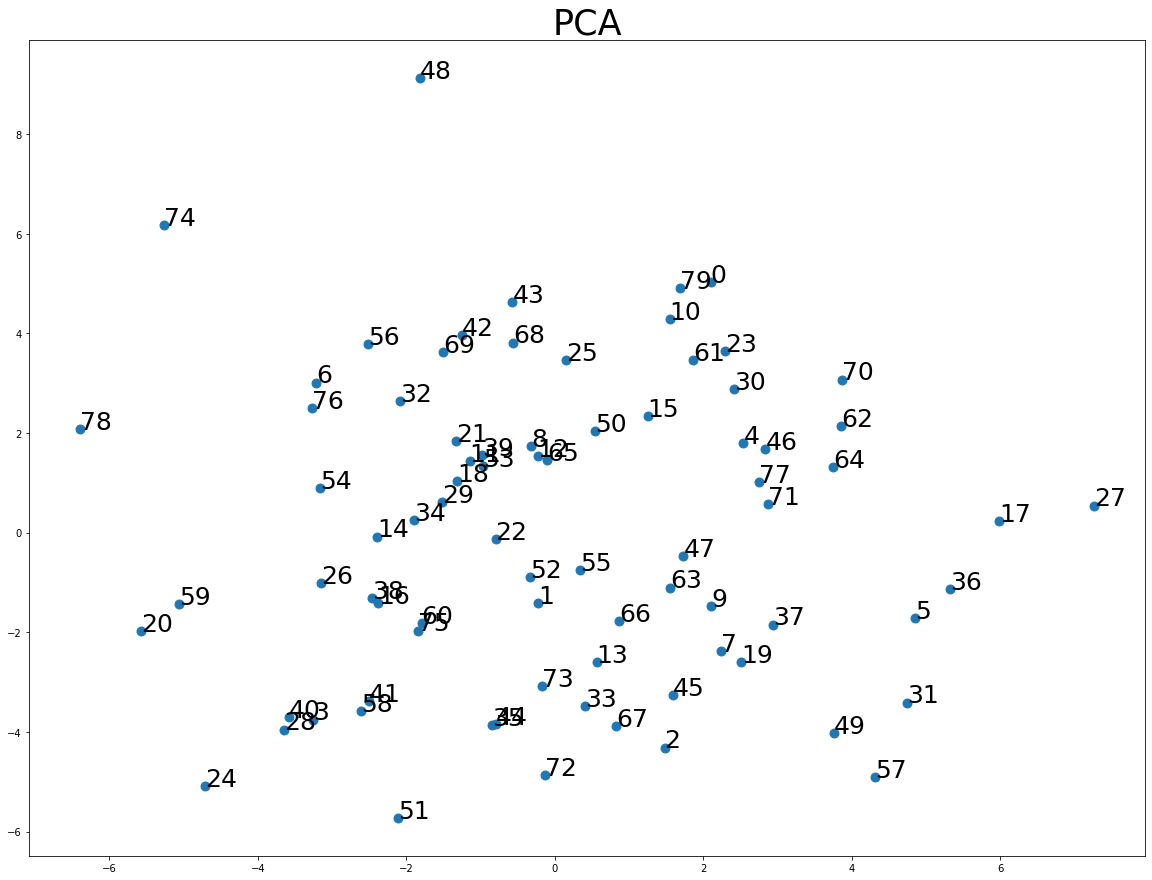

In [27]:
principal_df = pd.DataFrame(pct,columns=['pc1','pc2'])

cols_names = [i.split('_')[0] for i in list(result_df_kt.columns)]

finaldf= pd.concat([principal_df,pd.Series(cols_names)],axis=1)
finaldf.columns = ['pc1','pc2','target']
finaldf = finaldf.iloc[:]

y = list(finaldf.pc1)
z = list(finaldf.pc2)
n = list(finaldf.target)

fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(z, y, s=80)
plt.title('PCA',  fontsize=35)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=25)

### T-SNE

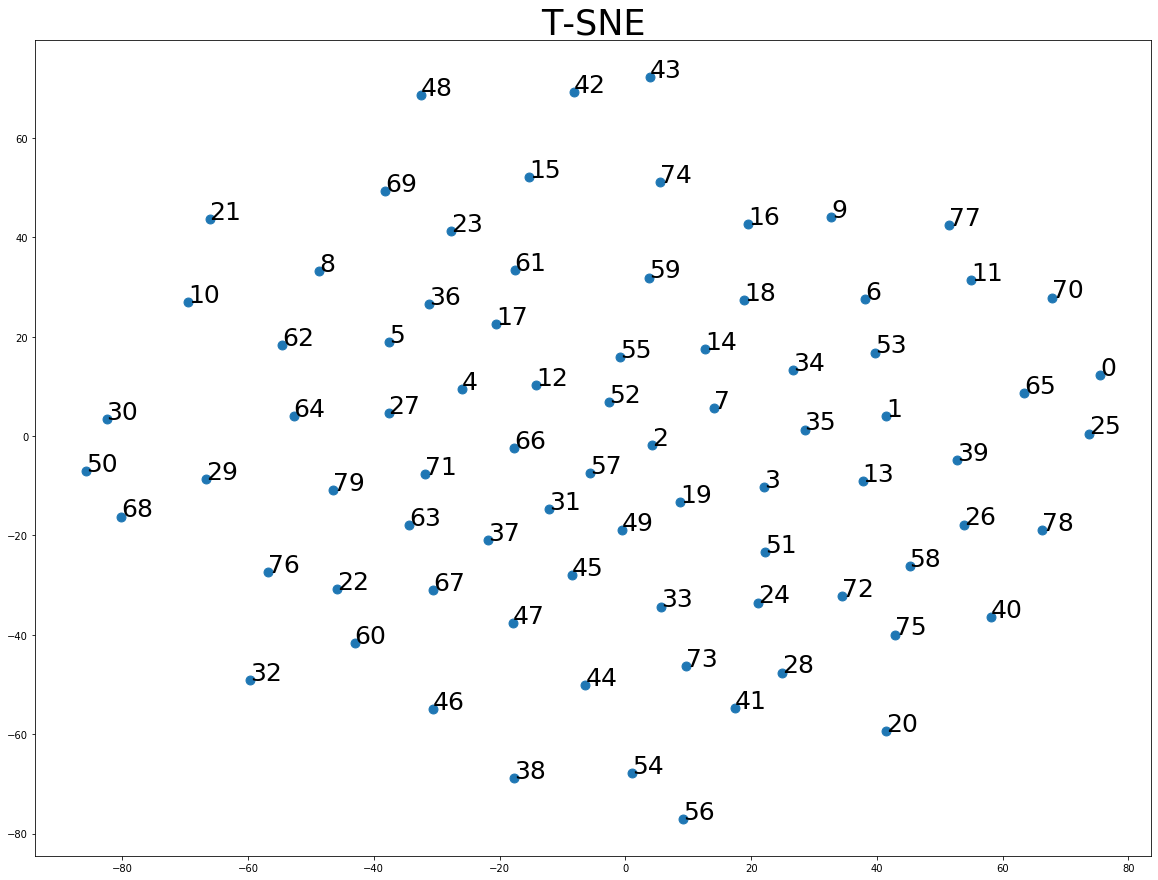

In [26]:
tsne = TSNE(n_components = 2).fit_transform(X)

principal_df = pd.DataFrame(tsne,columns=['pc1','pc2'])

cols_names = [i.split('_')[0] for i in list(result_df_kt.columns)]

finaldf= pd.concat([principal_df,pd.Series(cols_names)],axis=1)
finaldf.columns = ['pc1','pc2','target']
finaldf = finaldf.iloc[:]

y = list(finaldf.pc1)
z = list(finaldf.pc2)
n = list(finaldf.target)

fig, ax = plt.subplots(figsize=(20,15))

ax.scatter(z, y, s=80)
plt.title('T-SNE',  fontsize=35)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=25)